<a href="https://colab.research.google.com/github/gabonwilliams/thejourneybecauseimrusty/blob/main/ValidatingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 6.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
#dir = "/Users/dimitriskonstantellos/Desktop/"
#data = pd.read_csv(dir + "DataModel.csv")
from google.colab import files

uploaded = files.upload()


Saving DataModel.csv to DataModel.csv


In [ ]:
data = pd.read_csv("DataModel.csv")

In [ ]:
data.Dates = pd.to_datetime(data.Dates)
print(data)

          Dates  VIX_LAST  VIX_OPEN  SP_LAST  SP_OPEN    SP_VOLUME  EAFE_LAST  \
0    1990-01-02     17.24       NaN   359.69   353.39          0.0    1043.26   
1    1990-01-03     18.19       NaN   358.76   359.66          0.0    1044.80   
2    1990-01-04     19.22       NaN   355.67   358.74          0.0    1054.33   
3    1990-01-05     20.11       NaN   352.20   355.65          0.0    1046.18   
4    1990-01-08     20.26       NaN   353.79   352.19          0.0    1047.86   
...         ...       ...       ...      ...      ...          ...        ...   
8565 2024-01-05     13.35     14.24  4697.24  4690.57  650594292.0    2207.74   
8566 2024-01-08     13.08     14.00  4763.54  4703.70  699080100.0    2210.48   
8567 2024-01-09     12.76     13.20  4756.50  4741.93  627224821.0    2203.70   
8568 2024-01-10     12.69     12.86  4783.45  4759.94  594304429.0    2209.12   
8569 2024-01-11     12.44     12.64  4780.24  4792.13  639092565.0    2203.90   

      EAFE_OPEN  VVIX_LAST 

In [ ]:
data_regression = pd.DataFrame(columns=["Dates", "VIXR", "W", "P", "N", "V"])
data_regression["Dates"] = data["Dates"]
data_regression["VIXR"] =  np.log(data["VIX_LAST"]) -  np.log(data["VIX_LAST"]).shift(1)
data_regression["W"] = np.log(data["EAFE_LAST"]/data["EAFE_LAST"].shift(1))

SP_log_return = np.log(data["SP_LAST"]/data["SP_LAST"].shift(1))
data_regression["P"] = np.where(SP_log_return > 0, SP_log_return, 0)
data_regression["N"] = np.where(SP_log_return <= 0, SP_log_return, 0)

data_regression["V"] = np.log(data["SP_VOLUME"]) - np.log(data["SP_VOLUME"].shift(1))
print(data_regression)

          Dates      VIXR         W         P         N         V
0    1990-01-02       NaN       NaN  0.000000  0.000000       NaN
1    1990-01-03  0.053640  0.001475  0.000000 -0.002589       NaN
2    1990-01-04  0.055079  0.009080  0.000000 -0.008650       NaN
3    1990-01-05  0.045266 -0.007760  0.000000 -0.009804       NaN
4    1990-01-08  0.007431  0.001605  0.004504  0.000000       NaN
...         ...       ...       ...       ...       ...       ...
8565 2024-01-05 -0.056784  0.002358  0.001824  0.000000 -0.063165
8566 2024-01-08 -0.020432  0.001240  0.014016  0.000000  0.071879
8567 2024-01-09 -0.024769 -0.003072  0.000000 -0.001479 -0.108460
8568 2024-01-10 -0.005501  0.002456  0.005650  0.000000 -0.053913
8569 2024-01-11 -0.019897 -0.002366  0.000000 -0.000671  0.072658

[8570 rows x 6 columns]


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Rebuild Model from Paper

In [ ]:
# Shift Data for Model
#data_regression["VIXR_shifted"] = data_regression["VIXR"].shift(1)
data_regression["P_shifted"] = data_regression["P"].shift(1)
data_regression["N_shifted"] = data_regression["N"].shift(1)
data_regression["V_shifted"] = data_regression["V"].shift(1)

In [ ]:
# Get Data for each period under investigation
P1 = data_regression[(data_regression["Dates"] <= "2002-12-31") & (data_regression["Dates"] >= "1990-01-01")].reset_index(drop = True)
P2 = data_regression[(data_regression["Dates"] <= "2002-12-31") & (data_regression["Dates"] >= "1997-10-01")].reset_index(drop = True)
P3 = data_regression[(data_regression["Dates"] <= "2002-12-31") & (data_regression["Dates"] >= "1999-01-04")].reset_index(drop = True)
P4 = data_regression[(data_regression["Dates"] <= "2002-12-31") & (data_regression["Dates"] >= "2000-12-29")].reset_index(drop = True)
TestSet = data_regression[(data_regression["Dates"] <= "2004-12-31") & (data_regression["Dates"] >= "2003-01-01")].reset_index(drop = True)

In [ ]:
i = 1
for df in [P1, P2, P3, P4]:
  print("Period {}: ".format(i) + str(len(df)) + " " + "rows")
  i += 1

Period 1: 3277 rows
Period 2: 1319 rows
Period 3: 1004 rows
Period 4: 501 rows


In [ ]:
def in_sample_r2(model_results, df, plot = True):
  from sklearn.metrics import r2_score
  # Get in-sample predictions
  predictions = model_results.predict(start=0, end=len(df)-1)
  r2 = r2_score(df['VIXR'], predictions)
  if plot:
    # Plotting observed values and predicted values
    plt.plot(P2['VIXR'], label='Observed')
    plt.plot(P2.index, predictions, label='Predicted', color='red')
    plt.xlabel('Time')
    plt.ylabel('VIXR')
    plt.legend()
    plt.show()
    print('r2 score is', r2)
  return r2

In [ ]:
def replicate_model(period_df, model_choice, plot = True):
  #period_df = period_df.dropna()
  order = (1, 0, 1)
  if model_choice == 1:
      model = ARIMA(period_df['VIXR'], order=order)
  elif model_choice == 3:
      model = ARIMA(period_df['VIXR'], exog=period_df[['W', 'P_shifted', 'N_shifted']], order=order)
  elif model_choice == 5:
      model = ARIMA(period_df['VIXR'], exog=period_df[['W', 'P_shifted', 'N_shifted', 'V_shifted']], order=order)
  else:
    return("Model "+ str(model_choice) + " " + "not yet implemented")
  res = model.fit()
  aic_value = res.aic
  bic_value = res.bic
  r2 = in_sample_r2(res, period_df, False)
  coefs = res.params
  if plot:
    print(res.summary())
    print(res.plot_diagnostics())
    print("AIC: " + str(aic_value))
    print("BIC: " + str(bic_value))
    print("R2: " + str(r2))
  out = {'Model': res, 'coefs': coefs, 'R2': r2, 'BIC': bic_value}
  return out


## **Example: Implement Model #1 on Period 2**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                   VIXR   No. Observations:                 1319
Model:                 ARIMA(1, 0, 1)   Log Likelihood                1891.538
Date:                Mon, 15 Jan 2024   AIC                          -3775.076
Time:                        22:16:17   BIC                          -3754.337
Sample:                             0   HQIC                         -3767.300
                               - 1319                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.159      0.874      -0.002       0.002
ar.L1          0.7951      0.068     11.688      0.000       0.662       0.928
ma.L1         -0.8706      0.055    -15.904      0.0

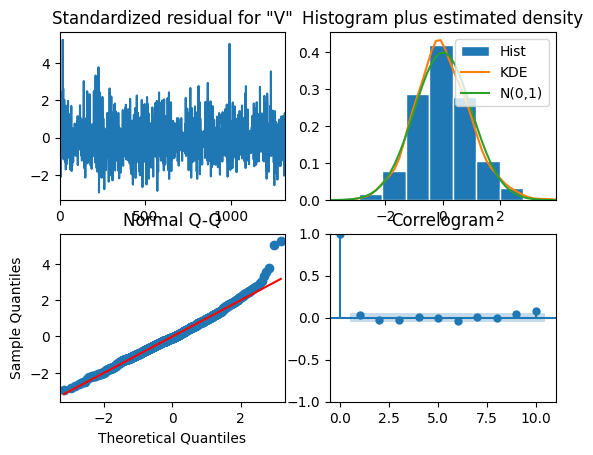

In [ ]:
model1_P2 = replicate_model(P2, 1, True)

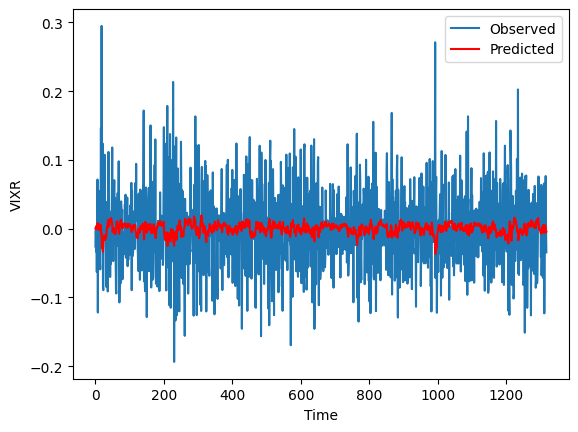

r2 score is 0.01528104781616979


0.01528104781616979

In [ ]:
in_sample_r2(model1_P2['Model'], P2, True)

## **Example: Implement Model #3 on Period 2**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                   VIXR   No. Observations:                 1319
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2029.363
Date:                Mon, 15 Jan 2024   AIC                          -4044.725
Time:                        22:00:24   BIC                          -4008.433
Sample:                             0   HQIC                         -4031.118
                               - 1319                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      1.905      0.057   -8.13e-05       0.006
W             -2.2474      0.124    -18.123      0.000      -2.490      -2.004
P_shifted      0.1080      0.182      0.594      0.5

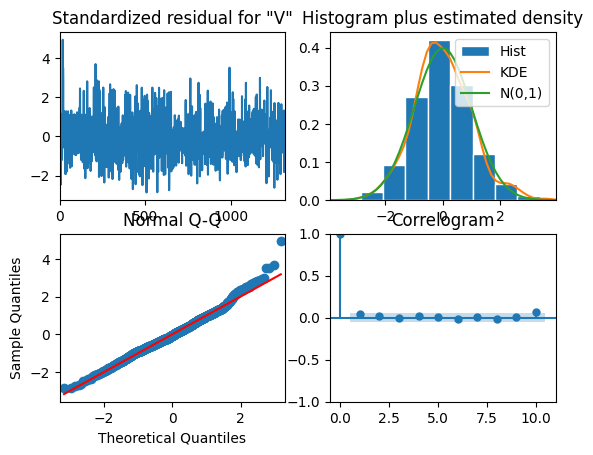

In [ ]:
model3_P2 = replicate_model(P2, 3, True)


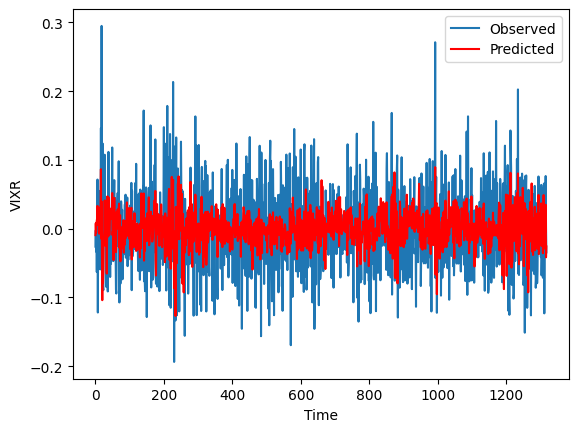

r2 score is 0.2010238001563045


0.2010238001563045

In [ ]:
in_sample_r2(model3_P2['Model'], P2)

## **Example: Implement Model # 5 on Period 2**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                   VIXR   No. Observations:                 1319
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2030.461
Date:                Mon, 15 Jan 2024   AIC                          -4044.922
Time:                        22:02:59   BIC                          -4003.444
Sample:                             0   HQIC                         -4029.370
                               - 1319                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.245      0.213      -0.001       0.006
W             -2.1660      0.126    -17.176      0.000      -2.413      -1.919
P_shifted      0.1559      0.197      0.789      0.4

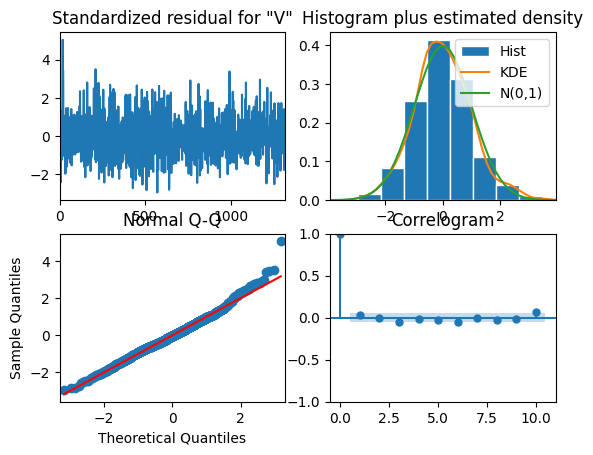

In [ ]:
model5_P2 = replicate_model(P2, 5, True)

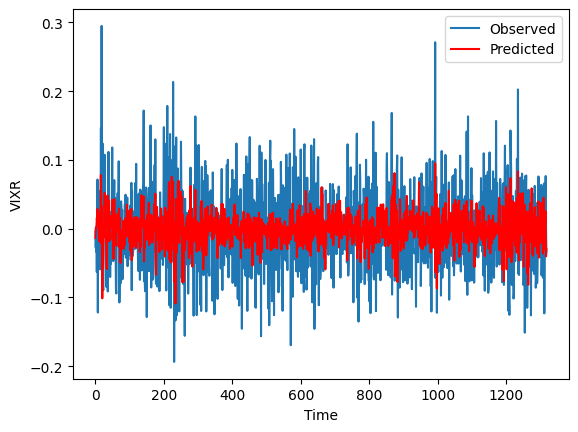

r2 score is 0.20233230370856858


0.20233230370856858

In [ ]:
in_sample_r2(model5_P2['Model'], P2)

## **Get Model Summary across all 4 periods**

In [ ]:
import warnings
# Suppress user warnings
warnings.filterwarnings("ignore", category=UserWarning)

models_list = [1, 3, 5]
period = 2
for df_i in [P2, P3, P4]:
  series_list = []
  for j in models_list:
    model_ij = replicate_model(df_i, j, False)
    #print(model_ij['coefs'])
    # Put the Series in a list
    series_ij = model_ij['coefs']
    r2_entry = pd.Series([model_ij['R2'], model_ij['BIC']], index=['R2', 'BIC'])
    series_ij = pd.concat([series_ij, r2_entry])
    series_list.append(series_ij)
  # Initialize the result DataFrame with the first Series
  result_i = pd.DataFrame(series_list[0], columns=['Model_{}'.format(models_list[0])])
  # Outer join the remaining Series to the DataFrame in a for loop
  for i, series in enumerate(series_list[1:], start=2):
      result_i = pd.merge(result_i, pd.DataFrame(series, columns=[f'Model_{models_list[i-1]}']),
                        left_index=True, right_index=True, how='outer')
  # Rename the columns based on the original Series names
  result_i.columns = [f'{col}_coef' for col in result_i.columns]
  print("----------- Period {} -----------".format(period))
  print(result_i)
  print("-----------------------------------")
  print(" ")
  print(" ")
  print(" ")
  print(" ")
  period += 1


----------- Period 2 -----------
           Model_1_coef  Model_3_coef  Model_5_coef
BIC        -3754.337154  -4008.433071  -4003.444484
N_shifted           NaN      0.722103      0.667405
P_shifted           NaN      0.107957      0.155865
R2             0.015281      0.201024      0.202332
V_shifted           NaN           NaN     -0.019426
W                   NaN     -2.247412     -2.165964
ar.L1          0.795105      0.691184      0.564047
const          0.000170      0.002827      0.002198
ma.L1         -0.870567     -0.841623     -0.692653
sigma2         0.003325      0.002690      0.002706
-----------------------------------
 
 
 
 
----------- Period 3 -----------
           Model_1_coef  Model_3_coef  Model_5_coef
BIC        -2935.776035  -3106.471637  -3100.959066
N_shifted           NaN      0.739272      0.672586
P_shifted           NaN      0.099092      0.138494
R2             0.023413      0.192889      0.193973
V_shifted           NaN           NaN     -0.014241
W     